In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyod.utils.data import generate_data

X_train, X_test, y_train, y_test = generate_data(n_train=20000, n_test=2000, n_features=300, contamination=0.1, random_state=0)

In [2]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

n_features = 300
latent_dim = 100

# 인코더
enc_inputs = layers.Input(shape=(n_features,))
x = layers.Dense(200, activation='relu')(enc_inputs)
enc_outputs = layers.Dense(latent_dim, activation='relu')(x) # Latent vector

encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# 디코더
dec_inputs = layers.Input(shape=(latent_dim,)) # Latent vector
x = layers.Dense(200, activation='relu')(dec_inputs)
dec_outputs = layers.Dense(n_features, activation='linear')(x) # 데이터를 보고 거기에 맞춰서 활성화 함수 사용 

decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# 오토인코더
inputs = layers.Input(shape=(n_features,))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs=inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='mse') # 오차 구하는 것 중에 미분이 잘 되는 것 mse
AE.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 model (Functional)          (None, 100)               80300     
                                                                 
 model_1 (Functional)        (None, 300)               80500     
                                                                 
Total params: 160,800
Trainable params: 160,800
Non-trainable params: 0
_________________________________________________________________


In [8]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
Total params: 80,300
Trainable params: 80,300
Non-trainable params: 0
_________________________________________________________________


In [9]:
AE.fit(X_train_sc, X_train_sc, validation_split=0.2, batch_size=128, epochs=20) # 압축 후 복원하기 때문에, 자신과 비교

Epoch 1/20
125/125 [==============================] - 1s 3ms/step - loss: 0.1925 - val_loss: 15.6292
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 14.3585
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1650 - val_loss: 15.4082
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1625 - val_loss: 16.8591
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1615 - val_loss: 17.3897
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1607 - val_loss: 18.0068
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1603 - val_loss: 18.6129
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1598 - val_loss: 19.0603
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1595 - val_loss: 19.2863
Epoch 10/20
125/125 [==============================] - 0s 1ms/step - loss: 0.1587 - val_los

In [10]:
p_test = AE.predict(X_test_sc)
p_test.shape

63/63 [==============================] - 0s 2ms/step


(2000, 300)

In [12]:
# 재건에러
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=1)

rce = reconstruction_error(X_test_sc, p_test)

In [14]:
rce.shape

(2000,)

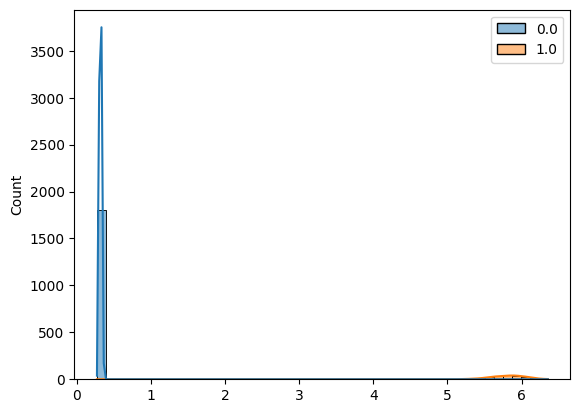

In [25]:
plt.figure()
sns.histplot(x=rce, hue=y_test, bins=50, kde=True)
# plt.yscale('log')
plt.show()

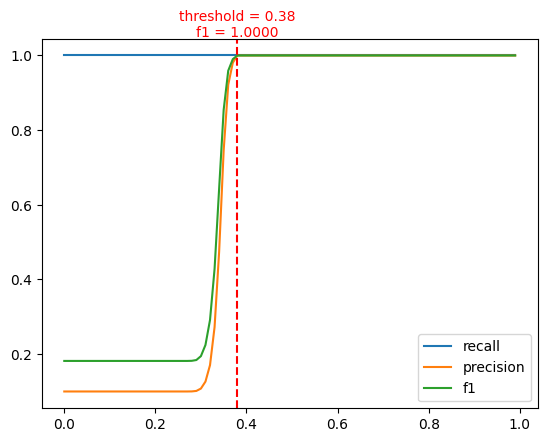

In [27]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve

recall = []
precision = []
f1 = []

thresholds = np.arange(0, 1, 0.01)
for thres in thresholds:
    results = rce > thres
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))

plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

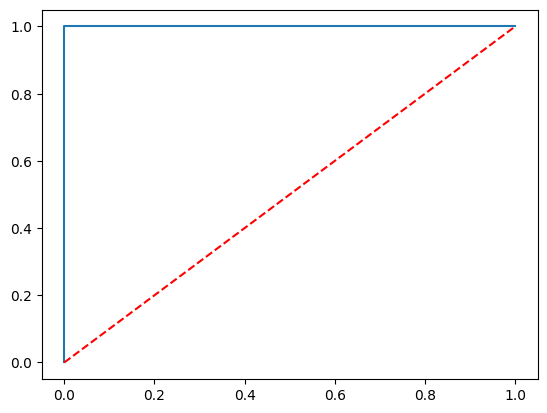

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, rce)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.show()

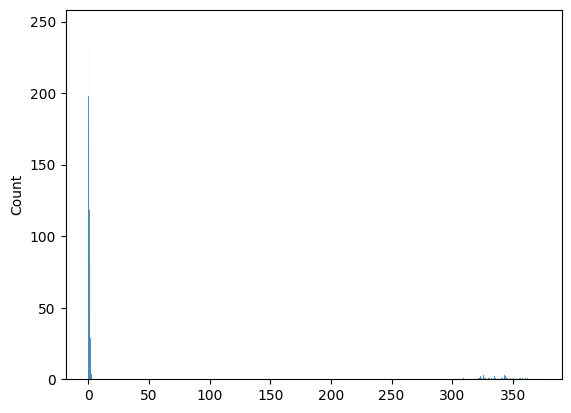

In [33]:
def mod_z(f): # 2 이상이면 이상치
    med_f = np.median(f)
    med_abs_dev = np.median((np.abs(f - med_f)))
    mod_z = 0.7413 * ((f - med_f) / med_abs_dev)
    return np.abs(mod_z)

mod_z = mod_z(rce)
sns.histplot(mod_z)
plt.show()